#AOS1 homework4

author: Chen GONG Yunfei ZHAO

date: 10/nov/2020

## Introduction
For this home work, we will predict the cumulated debit card usage during the 4 first months of 2013 through time series. The data we have comes from the file data/debitcards.csv, which records the monthly retail debit card usage in Iceland (million ISK) from january 2000 to december 2012. 

The python library we used is below:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX as sarimax
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts

## Data presentation

In [ ]:
data = pd.read_csv("data/debitcards.csv", parse_dates=True, index_col=0)
data.index.freq = "MS"
assert(type(data.index) is pd.core.indexes.datetimes.DatetimeIndex)

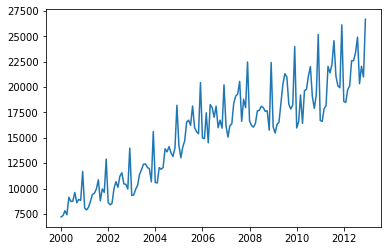

In [ ]:
plt.plot(data)

##Test the stationarity
From the above figure, we think that the data has a upward trend, so we test the stationarity of the time series by applying an Augmented Dickey-Fuller statistical test.

In [ ]:
test = adfuller(data['V1'], autolag='AIC')
pvalue = test[1]
print(pvalue)

0.7881064417185542


The p-value is less than 0.788, so we can not reject the null hypothesis with strong confidence and we may say that the time series is not stationary and also based on the figure, we can conclude that the data set is not a stationary data set. So we need to process the data first. We use the method difference to make a stationary time series, then we will use the model ARIMA. 

##Difference
The differencing operator $∇$ means $∇Y_{t} = Y_{t} − Y_{t-1}$.

We want to make a difference first and observe the p value. If the time series is still unstable, we will continue the differential operation until it stabilizes.

In [ ]:
data['V1'].diff(1)

2000-01-01       NaN
2000-02-01     131.0
2000-03-01     477.0
2000-04-01    -399.0
2000-05-01    1723.0
               ...  
2012-08-01    1541.0
2012-09-01   -4595.0
2012-10-01    1713.0
2012-11-01   -1050.0
2012-12-01    5687.0
Freq: MS, Name: V1, Length: 156, dtype: float64

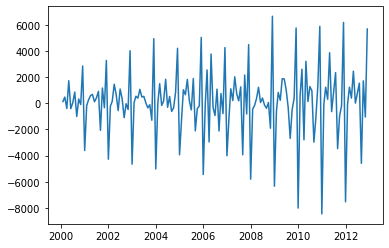

In [ ]:
Diff_data = data['V1'].diff(1).dropna()
plt.plot(Diff_data)

In [ ]:
test = adfuller(Diff_data, autolag='AIC')
pvalue = test[1]
print(pvalue)

0.03815703587781361


After the difference, A p-value less than 0.05 (typically ≤ 0.05) is statistically significant. It indicates strong evidence against the null hypothesis, as there is less than a 5% probability the null is correct (and the results are random). Therefore, we reject the null hypothesis, and accept the alternative hypothesis. we think at this time it is a stable time series.

##ACF and PACF

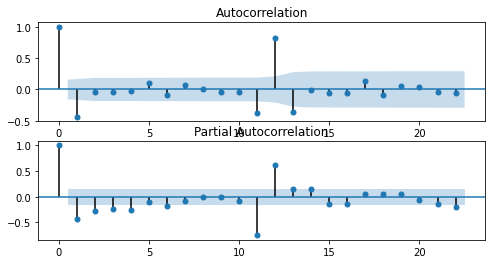

In [ ]:
fig, ax = plt.subplots(2, figsize=(8, 4))
plot_acf(Diff_data, ax=ax[0])
plot_pacf(Diff_data, ax=ax[1])
plt.show()

We can see that in the ACF image, the third point falls within the confidence interval. In the PACF image, the sixth point falls within the confidence interval. So we take p = 4, q = 1, then we have AR(4) and MA(1).

## Split data
We first split the data set by 01 January 2010, we want to test on the test set and compare the results with the training set. If the resulting MSE is small, we will apply the model to the overall data and predict the situation in the first four months of 2013. Otherwise, we will consider improving the model.


In [ ]:
data_train = data[:"2010-01-01"] 
data_test = data["2010-01-01":]

## Model ARIMA

In [ ]:
model_train = sarimax(data_train['V1'], order=(4, 1, 1))
model_fit = model_train.fit()

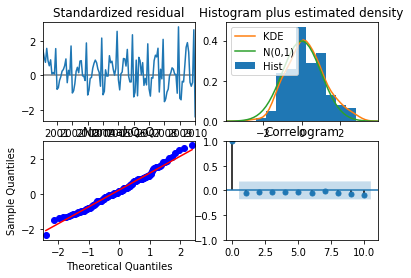

In [ ]:
fig = model_fit.plot_diagnostics()

Looking at the histogram of residuals and a normal Q-Q-plot, we see that the residuals seem to be normally distributed. Plus, the correlogram shows that they are not correlated.

And now we are going to evaluate our model.

In [ ]:
model_test = sarimax(data, order=(4, 1, 1))
model_test_res = model_test.filter(model_fit.params)
pred = model_test_res.get_prediction(start="2010-01-01")
pred_ci = pred.conf_int()

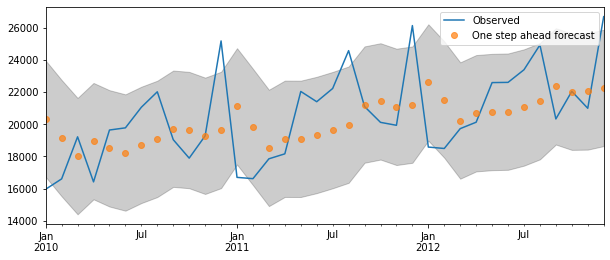

In [ ]:
ax = data_test.plot(y="V1", label="Observed", figsize=(10, 4)) 
pred.predicted_mean.plot(ax=ax, label="One step ahead forecast", alpha=0.7, linestyle='', marker='o')
ax.fill_between(pred_ci.index, pred_ci['lower V1'], pred_ci['upper V1'], color="k", alpha=0.2)
plt.legend()

In [ ]:
mse = np.mean((pred.predicted_mean - data_test.V1)**2)
print(f"mean quare error is: {mse}")

mean quare error is: 7187055.259112614


In [ ]:
np.sqrt(mse)

2680.86837780459

## Prediction results

In [ ]:
model = sarimax(data['V1'], order=(4, 1, 1))
model_fit = model.fit()
pred = model_fit.get_prediction(start="2013-01-01",end="2013-04-01")
pred_ci = pred.conf_int()
pred_ci

,lower V1,upper V1
2013-01-01,19249.632216,27316.297414
2013-02-01,18693.504419,27031.234546
2013-03-01,18421.843086,26894.199080
2013-04-01,18544.931821,27111.725624


In [ ]:
pred.predicted_mean.to_frame(name="debit card usage mean")

,debit card usage mean
2013-01-01,23282.964815
2013-02-01,22862.369483
2013-03-01,22658.021083
2013-04-01,22828.328722


In [ ]:
pred.predicted_mean.cumsum().to_frame(name="accumulated debit card usaga")

,accumulated debit card usaga
2013-01-01,23282.964815
2013-02-01,46145.334298
2013-03-01,68803.355380
2013-04-01,91631.684103


## Model SARIMA and take seasonal into account
Below we carry out the seasonal forecast. From the original data, we think that the data changes regularly with the year. So we first conduct a seasonal analysis.

<Figure size 1080x504 with 0 Axes>

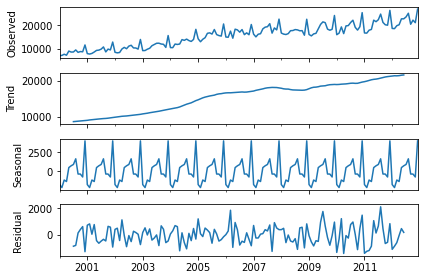

In [ ]:
decomposition = seasonal_decompose(data['V1'],freq=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
 
plt.figure(figsize=[15, 7])
a = decomposition.plot()

In the above figure, the first grid image is the image of the original data, the second grid image is the trend image of the data, we can see the obvious upward trend, and the third grid image is the seasonal trend, we can see that the image shows our guess, The seasonal trend of unconventional moments is at hand, and the last grid is the residual part.

In [ ]:
model_train = sarimax(data_train["V1"], order=(4, 1, 1), seasonal_order=(4, 1, 1, 12))
model_fit = model_train.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


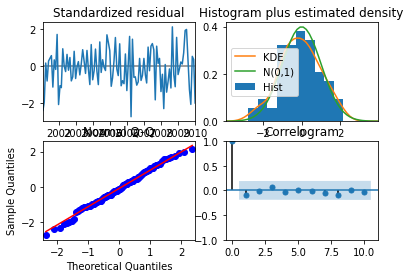

In [ ]:
fig = model_fit.plot_diagnostics()

In [ ]:
model_test = sarimax(data["V1"], order=(4, 1, 1), seasonal_order=(4, 1, 1, 12))
model_test_res = model_test.filter(model_fit.params)
pred = model_test_res.get_prediction(start="2010-01-01")
pred_ci = pred.conf_int()

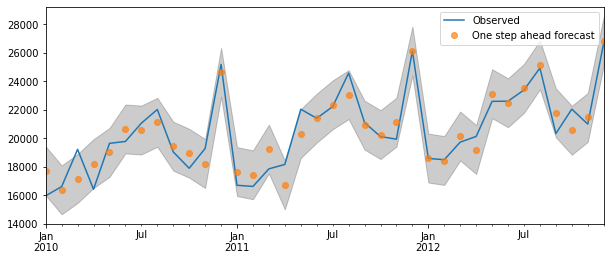

In [ ]:
ax = data_test.plot(y="V1", label="Observed", figsize=(10, 4)) 
pred.predicted_mean.plot(ax=ax, label="One step ahead forecast", alpha=0.7, linestyle='', marker='o')
ax.fill_between(pred_ci.index, pred_ci['lower V1'], pred_ci['upper V1'], color="k", alpha=0.2)
plt.legend()

In [ ]:
mse = np.mean((pred.predicted_mean - data_test.V1)**2)
print(f"mean quare error is: {mse}")

mean quare error is: 932513.0667831323


In [ ]:
np.sqrt(mse)

965.6671614915422

This time the MSE is an order of magnitude smaller than before, indicating that considering seasonality has greatly improved our model.

## Prediction results

In [ ]:
model = sarimax(data['V1'], order=(4, 1, 1), seasonal_order=(4, 1, 1, 12))
model_fit = model.fit()
pred = model_fit.get_prediction(start="2013-01-01",end="2013-04-01")
pred_ci = pred.conf_int()
pred_ci

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,lower V1,upper V1
2013-01-01,17963.630934,21317.060350
2013-02-01,17573.018768,21162.347962
2013-03-01,18528.031046,22230.837919
2013-04-01,18802.872920,22801.809510


In [ ]:
pred.predicted_mean.to_frame(name="debit card usage mean")

,debit card usage mean
2013-01-01,19640.345642
2013-02-01,19367.683365
2013-03-01,20379.434483
2013-04-01,20802.341215


In [ ]:
pred.predicted_mean.cumsum().to_frame(name="accumulated debit card usaga")

,accumulated debit card usaga
2013-01-01,19640.345642
2013-02-01,39008.029007
2013-03-01,59387.463490
2013-04-01,80189.804704


##Conclusion
We used two methods for forecasting. We believe that the results are in line with expectations and the overall trend is on the rise. And the seasonal have a great influence of the data and with taking it into account we got a result 10 times better then ARMA model. The final prediction result is below.
According to the data, we can see that the beginning of each year is the lowest point of the data, and our forecast chart also conforms to this law. So we believe that the model has worked well.

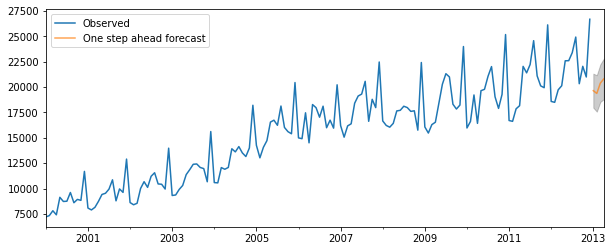

In [ ]:
ax = data.plot(y="V1", label="Observed", figsize=(10, 4))
pred.predicted_mean.plot(ax=ax, label="One step ahead forecast", alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci['lower V1'], pred_ci['upper V1'], color="k",alpha=0.2)
plt.legend()